In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

import itertools
from gensim.models import Word2Vec, KeyedVectors
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
stop_words = stopwords.words('english') + \
            ['et', 'al', 'fig', 'figs', 'figure', 'table', 'also',
            'using', 'found', 'observed', 'however', 'previous', 'study',
            'although', 'studies', 'several', 'showed', 'could', 
            'performed', 'known', 'methods', 'whether', 'materials',
            'known', 'analyzed', 'within', 'show', 'respectively', 
            'thus', 'therefore', 'tested', 'among', 'abstract', 
            'introduction', 'may', 'shown', 'results', 'interestingly',
            'either', 'similarly', 'furthermore', 'consistently', 
            'neither', 'one', 'two', 'three', 'four', 'five', 'six',
            'seven', 'eigh', 'nine', 'ten', 'eleven', 'twelve', 
            'thirteen', 'fourteen', 'fifteen', 'sixteen', 'seventeen',
            'eighteen', 'nineteen', 
            'supplemental']


In [36]:
# testing regex; as a token of the efford (a few hours spent) I leave this rule here
#sp  = re.compile(r'(\b)[!-](' + r'|'.join(stopwords.words('english')+stop_words) + r')\b\s*')
sp  = re.compile(r'(?<!-)\b(' + r'|'.join(stop_words) + r').\b\s*')
s = sp.sub(' x ', 'a Fromage amk ia hla-a a one I a i one 2a')
#s = sp.sub(' x ', s)
s

' x Fromage  x  x hla-a  x  x I  x  x  x 2a'

In [4]:
#stop_pattern = re.compile(r'\b(' + r')\b\s*')
#stop_pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
#stop_pattern = re.compile(r'\b(' + r'|'.join(stop_words) + r')\b\s*')
#stop_pattern = re.compile(r'\b('  + r'|'.join(stopwords.words('english')+stop_words) + r')\b\s*')
#stop_pattern = re.compile(r'-{0}\b(' + r'|'.join(stopwords.words('english')+stop_words) + r')\b\s*')
stop_pattern = re.compile(r'(?<!-)\b(' + r'|'.join(stopwords.words('english')+stop_words) + r')\b(?!-)\s*')

def get_cleaned_text2(fname, max_len=999999):
    all_words = []
    with open(fname, 'r') as f:
        for n, line in enumerate(f):
            if n and n<max_len:
                line_id, line_text = line.split('||')
                # this regex should remove all the lone numbers, i.e, numbers that are not part of words
                #line_text = re.sub(r"$\d+\W+|\b\d+\b|\W+\d+$", " ", line_text) 
                line_text = re.sub(r"(?<!-)\b\d+\b", " ", line_text)
                # keep letters, numbers and a few characters that are seen in words;
                # substitute other characters with a space
                line_text = re.sub("[^\w\-\*\_]", " ", line_text)
                #line_text = re.sub("[\s.,()\'\`\"\’\‘]", " ", line_text)
                #print(line_text)        
                #line_text = re.sub("[^\w\-\*\_]", " ", line_text)

                line_letters_low = line_text.lower()
                line_letters_low = stop_pattern.sub(' ', line_letters_low)
                line_words = line_letters_low.split()
                line_words = [s for s in line_words if len(s) > 2]
                all_words.append(line_words)
                #all_words.append(line_letters_low)
                #print(len(all_words), len(line_letters_low))
    return all_words

xx = get_cleaned_text2('../data/x')
xx

[['znf198-fgfr1',
  'transformed',
  'elevated',
  'nkx2-1',
  'mef2c',
  'levels',
  'patients',
  'new',
  'variant',
  'recognized',
  'non-expressed',
  'hla',
  'class',
  'a-hla',
  'hla-a',
  'hla-b',
  'hla-c',
  'hla-g',
  'class',
  'hla-drb4',
  'hla-drb5',
  'hla-dpb1',
  'alleles',
  'a-hla',
  'hla-a',
  'alleles',
  'reduced',
  'expression',
  'hla-a*02010102l',
  'hla-a*24020102l',
  'hla-b',
  'variant',
  'exclusively',
  'secreted',
  'without',
  'present',
  'cell',
  'surface',
  'hla-b*44020102s'],
 ['new',
  'variant',
  'recognized',
  'non-expressed',
  'hla',
  'class',
  'hla-a',
  'hla-b',
  'hla-c',
  'hla-g',
  'class',
  'hla-drb4',
  'hla-drb5',
  'hla-dpb1',
  'alleles',
  'hla-a',
  'alleles',
  'reduced',
  'expression',
  'hla-a*02010102l',
  'hla-a*24020102l',
  'hla-b',
  'variant',
  'exclusively',
  'secreted',
  'without',
  'present',
  'cell',
  'surface',
  'hla-b*44020102s']]

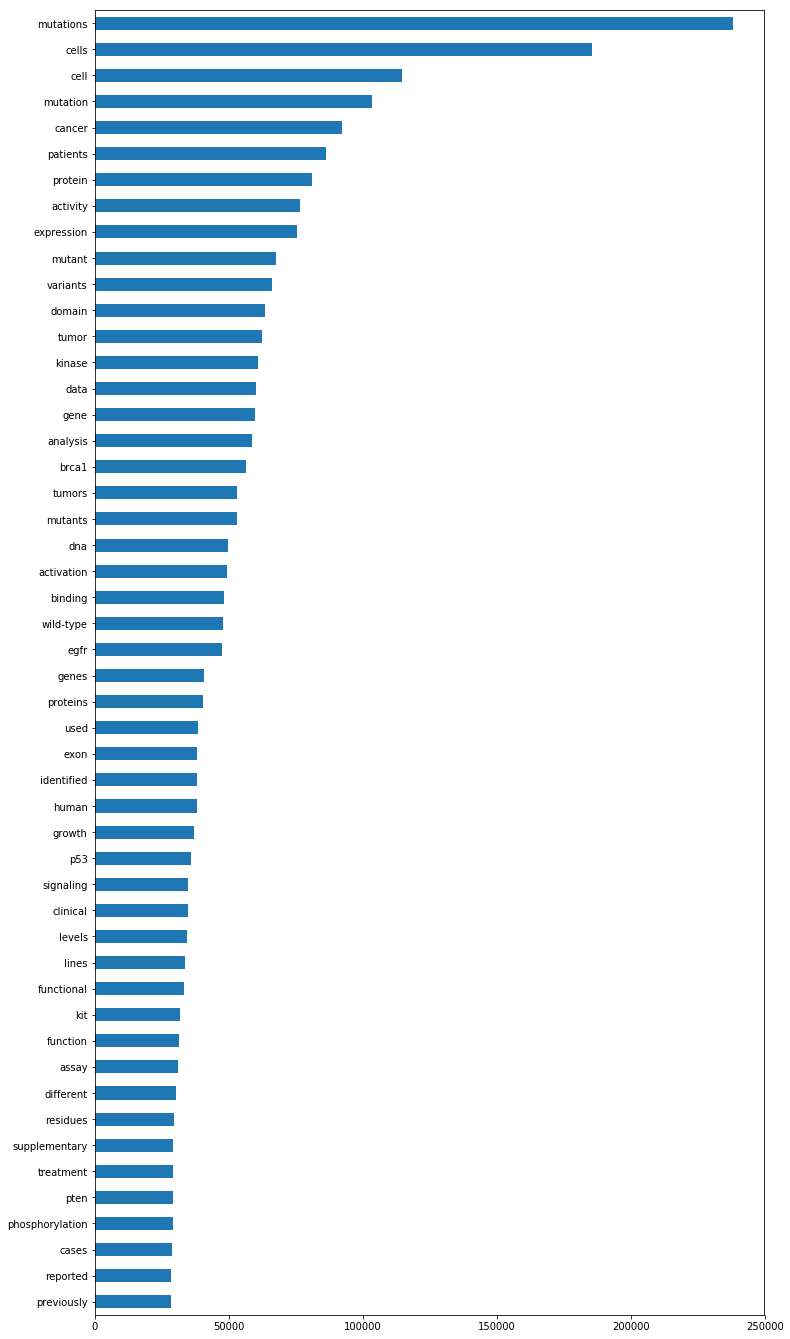

In [5]:
fname = '../data/training_text'

train_text2 = get_cleaned_text2(fname, 299999)

flatw = [w for a in train_text2 for w in a]
x = pd.DataFrame(flatw)
fig = x[0].value_counts()[:50].plot(kind='barh', figsize=(12,24))
fig.axes.invert_yaxis()

In [7]:
w2v_model = Word2Vec(train_text2, size=200, window=10, min_count=5, workers=4, iter=10)
#w2v_model = Word2Vec(train_text2, size=20, window=2, min_count=5, workers=4, iter=1)

In [8]:
w2v_model.wv['fam58a']

array([ -3.15716267e-01,  -1.29928708e-01,   4.15431596e-02,
         2.00878724e-01,  -3.71076018e-01,   8.74942392e-02,
         3.42206925e-01,   1.36109322e-01,  -5.94726741e-01,
        -8.97437055e-03,  -7.31394142e-02,   4.68721718e-01,
        -5.51237702e-01,   1.24831170e-01,   2.90723946e-02,
         3.07405621e-01,   1.38493165e-01,   2.37775296e-01,
        -3.56908818e-03,   3.71080309e-01,   9.77967903e-02,
         7.17167199e-01,   2.15841636e-01,  -5.67404144e-02,
         3.63356113e-01,   3.61682534e-01,  -6.95810392e-02,
         2.89577097e-01,  -4.31731880e-01,   3.12264562e-01,
        -5.55668175e-01,   4.66377586e-01,  -3.52875233e-01,
        -9.03731808e-02,   7.52069354e-01,   7.58352935e-01,
         3.19493890e-01,  -6.03133500e-01,  -6.76836520e-02,
         1.64360404e-02,  -1.61762014e-01,  -2.84321941e-02,
        -3.65125149e-01,   6.41547889e-02,   4.77610171e-01,
         3.91086608e-01,   1.61918451e-03,   1.56873271e-01,
        -6.20694757e-01,

In [9]:
w2v_model.wv.most_similar(positive='gene')

[('genes', 0.7226719260215759),
 ('oncogene', 0.4690258800983429),
 ('locus', 0.4538278877735138),
 ('chromosome', 0.43297189474105835),
 ('p14arf', 0.4236075282096863),
 ('ctnna1', 0.4169495105743408),
 ('3q26', 0.40809309482574463),
 ('11p15', 0.4020674228668213),
 ('pcas', 0.40157756209373474),
 ('9p21', 0.4006381630897522)]

In [10]:
w2v_model.wv.most_similar(positive='cancer')

[('cancers', 0.7569494247436523),
 ('carcinoma', 0.5870542526245117),
 ('carcinomas', 0.5765119791030884),
 ('adenocarcinoma', 0.5615658760070801),
 ('tumors', 0.5177419781684875),
 ('tumor', 0.5161051750183105),
 ('carcinogenesis', 0.49105584621429443),
 ('urological', 0.48590022325515747),
 ('malignancy', 0.4706619381904602),
 ('s12-23181-tp-nt', 0.46637624502182007)]

In [11]:
w2v_model.wv.most_similar(positive='mutation')

[('mutations', 0.8042056560516357),
 ('substitution', 0.5558696985244751),
 ('alteration', 0.5308845639228821),
 ('variant', 0.4672101140022278),
 ('nov', 0.45753243565559387),
 ('allele', 0.4568362236022949),
 ('g12i', 0.45469987392425537),
 ('mutational', 0.4478090703487396),
 ('d86n', 0.42903637886047363),
 ('case', 0.4231385588645935)]

the word similarity is not too bad..and that's on trained data on only ~3000 texts

In [12]:
w2v_model.wv.most_similar_cosmul(positive=['gene', 'dna', 'mutation', 'alterations'])

[('mutations', 0.25869083404541016),
 ('alteration', 0.22079910337924957),
 ('genes', 0.18987292051315308),
 ('aberrations', 0.18197797238826752),
 ('cases', 0.18174341320991516),
 ('aberration', 0.17820151150226593),
 ('nov', 0.1723843812942505),
 ('locus', 0.1704505831003189),
 ('somatic', 0.16892552375793457),
 ('exons', 0.16764594614505768)]

well, it didn't guess cancer or tumor

In [13]:
# just to play
w2v_model.wv.most_similar(positive=['cancer'], negative=['dna'])

[('cancers', 0.5547575354576111),
 ('carcinoma', 0.39161917567253113),
 ('carcinomas', 0.39021676778793335),
 ('crc', 0.37580645084381104),
 ('nsclc', 0.36793050169944763),
 ('adenocarcinoma', 0.366909921169281),
 ('tumors', 0.3636401295661926),
 ('malignancies', 0.348476767539978),
 ('malignancy', 0.345069944858551),
 ('urological', 0.3399343192577362)]

In [37]:
#every word is a vector
# get some kind of mean vector for every text?
s1 = train_text2[0]
s1

['cyclin-dependent',
 'kinases',
 'cdks',
 'regulate',
 'variety',
 'fundamental',
 'cellular',
 'processes',
 'cdk10',
 'stands',
 'last',
 'orphan',
 'cdks',
 'activating',
 'cyclin',
 'identified',
 'kinase',
 'activity',
 'revealed',
 'work',
 'cdk10',
 'silencing',
 'increases',
 'ets2',
 'v-ets',
 'erythroblastosis',
 'virus',
 'e26',
 'oncogene',
 'homolog',
 '-driven',
 'activation',
 'mapk',
 'pathway',
 'confers',
 'tamoxifen',
 'resistance',
 'breast',
 'cancer',
 'cells',
 'precise',
 'mechanisms',
 'cdk10',
 'modulates',
 'ets2',
 'activity',
 'generally',
 'functions',
 'cdk10',
 'remain',
 'elusive',
 'demonstrate',
 'cdk10',
 'cyclin-dependent',
 'kinase',
 'identifying',
 'cyclin',
 'activating',
 'cyclin',
 'cyclin',
 'orphan',
 'cyclin',
 'product',
 'fam58a',
 'whose',
 'mutations',
 'cause',
 'star',
 'syndrome',
 'human',
 'developmental',
 'anomaly',
 'whose',
 'features',
 'include',
 'toe',
 'syndactyly',
 'telecanthus',
 'anogenital',
 'renal',
 'malformations

In [14]:
# as a first approximation, let's estimate the mean vector of each text; for later TODO some fancy projections
text_wv_mean = np.empty(shape=(len(train_text2), w2v_model.layer1_size))
for i, text in enumerate(train_text2):
    text_wv_mean[i,:] = np.array([w2v_model.wv[w] for w in text if w in w2v_model.wv.vocab]).mean(axis=0)

In [15]:
w2v_model.wv.similar_by_vector(text_wv_mean[0])

[('expression', 0.577950119972229),
 ('cyclin', 0.5530437231063843),
 ('mutant', 0.5471502542495728),
 ('cells', 0.5471117496490479),
 ('protein', 0.510331928730011),
 ('endogenous', 0.502662718296051),
 ('levels', 0.4905177354812622),
 ('wild-type', 0.4770055413246155),
 ('overexpression', 0.47434157133102417),
 ('p57kip2', 0.4614354372024536)]

mean vectors look not too bad..lets see how they project on the PCA base

In [16]:
train_variants = pd.read_csv('../data/training_variants')
classes = train_variants.Class.values
genes = list(set(train_variants['Gene']))
variations = list(set(train_variants['Variation']))

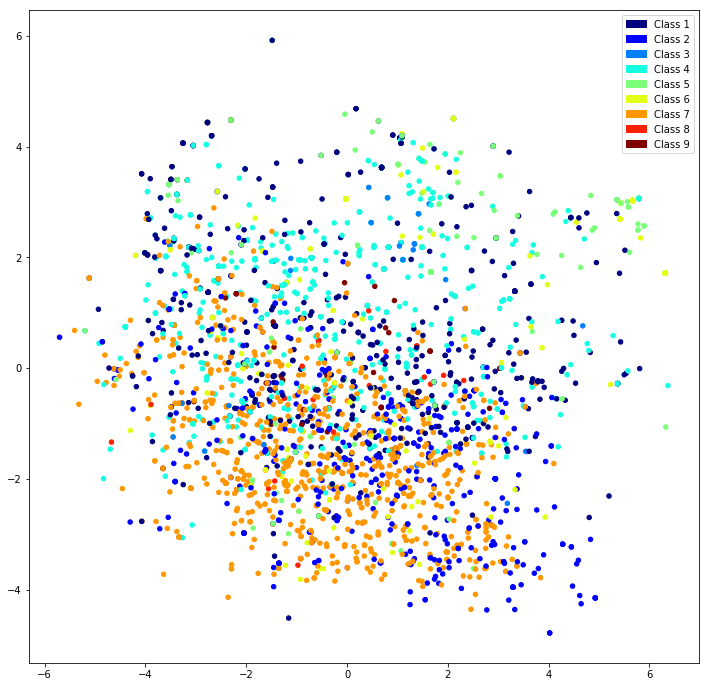

In [38]:
pca = PCA(n_components=2)
reduced_vecs = pca.fit_transform(text_wv_mean)

from matplotlib.patches import Patch

fig = plt.figure(figsize=(12,12))
ax = plt.subplot(111)
cm = plt.get_cmap('jet', 9)
colors = [cm(i/9) for i in range(9)]
ax.scatter(reduced_vecs[:,0], reduced_vecs[:,1], c=[colors[c-1] for c in classes], cmap='jet', s=20)
#plt.legend(['Class ' +str(i+1) for i in range(9)])
plt.legend(handles=[Patch(color=colors[i], label='Class {}'.format(i+1)) for i in range(9)])

not very good clustering; however, trying with more PCAs, better vector extraction (not mean w2v), 
and a better w2v model (pubmed) should do a better job; also word extraction can be improved to get the more complex words; how about ngrams?

In [39]:
forest = RandomForestClassifier(n_estimators=300, class_weight="balanced") 
forest = forest.fit(text_wv_mean, train_variants["Class"])

result_tr = forest.predict(text_wv_mean)
print("corr between prediction and real: ", np.corrcoef(result_tr, np.array(train_variants["Class"]))[0,1])

scores = cross_val_score(forest, text_wv_mean, train_variants["Class"], cv=10)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

corr between prediction and real:  0.862569233278
[ 0.4375      0.45833333  0.44011976  0.43243243  0.35435435  0.46385542
  0.58006042  0.61515152  0.59878419  0.4587156 ]
Accuracy: 0.48 (+/- 0.08)


In [40]:
forest = RandomForestClassifier(n_estimators=200) 
forest = forest.fit(text_wv_mean, train_variants["Class"])

result_tr = forest.predict(text_wv_mean)
print("corr between prediction and real: ", np.corrcoef(result_tr, np.array(train_variants["Class"]))[0,1])

scores = cross_val_score(forest, text_wv_mean, train_variants["Class"], cv=10)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

corr between prediction and real:  0.877453126156
[ 0.41666667  0.47916667  0.45808383  0.42942943  0.34834835  0.42168675
  0.52870091  0.6         0.57446809  0.47094801]
Accuracy: 0.47 (+/- 0.07)


In [41]:
forest = RandomForestClassifier(n_estimators=100) 
forest = forest.fit(text_wv_mean, train_variants["Class"])

result_tr = forest.predict(text_wv_mean)
print("corr between prediction and real: ", np.corrcoef(result_tr, np.array(train_variants["Class"]))[0,1])

scores = cross_val_score(forest, text_wv_mean, train_variants["Class"], cv=10)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

corr between prediction and real:  0.876519932119
[ 0.41666667  0.42857143  0.47904192  0.42642643  0.35135135  0.42771084
  0.52870091  0.6         0.58662614  0.4587156 ]
Accuracy: 0.47 (+/- 0.08)


In [42]:
forest = RandomForestClassifier(n_estimators=500) 
forest = forest.fit(text_wv_mean, train_variants["Class"])

result_tr = forest.predict(text_wv_mean)
print("corr between prediction and real: ", np.corrcoef(result_tr, np.array(train_variants["Class"]))[0,1])

scores = cross_val_score(forest, text_wv_mean, train_variants["Class"], cv=10, n_jobs=2)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

corr between prediction and real:  0.87717858388
[ 0.44047619  0.44940476  0.44311377  0.42342342  0.35735736  0.40361446
  0.53172205  0.62424242  0.58054711  0.4587156 ]
Accuracy: 0.47 (+/- 0.08)


In [43]:
fname = '../data/test_text'
test_text = get_cleaned_text2(fname)
test_data_features = np.empty(shape=(len(test_text), w2v_model.layer1_size))
for i, text in enumerate(test_text):
    test_data_features[i,:] = np.array([w2v_model.wv[w] for w in text if w in w2v_model.wv.vocab]).mean(axis=0)


In [44]:
result = forest.predict(test_data_features)
result_mat = np.zeros((len(result), 9))
    
test_id = np.arange(len(result))

result_mat[test_id, result-1] = 1
result_mat = result_mat.astype(int)
output = pd.DataFrame( data={"ID":test_id, "class1":result_mat[:,0],
        "class2":result_mat[:,1],
        "class3":result_mat[:,2],
        "class4":result_mat[:,3],
        "class5":result_mat[:,4],
        "class6":result_mat[:,5],
        "class7":result_mat[:,6],
        "class8":result_mat[:,7],
        "class9":result_mat[:,8]
        } )
output.to_csv( "w2v_on_text.csv", index=False)

here on, I play a bit to see how much 'Gene' names are found in text

In [45]:
train_variants

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4
5,5,CBL,V391I,4
6,6,CBL,V430M,5
7,7,CBL,Deletion,1
8,8,CBL,Y371H,4
9,9,CBL,C384R,4


In [46]:
for gene in genes:
    if gene.lower() not in w2v_model.wv.vocab:
        print(gene)

RAD54L
AR


In [47]:
for var in variations:
    if var.lower() not in w2v_model.wv.vocab:
        print(var)

G44S
P1776S
I834V
R1758G
G478C
G52R
Exon 19 insertion
L283_D294del
C41Y
P551_E554del
E580*
A2770T
SLC34A2-ROS1 Fusion
R2505*
A633V
S387N
V544_L545insAVLVLLVIVIISLI
M1663K
E60L
Delta-NTRK1 Fusion
S453fs*
SRGAP3-RAF1 Fusion
G101S
S65N
N588D
L46F
T75M
N535K
Y34C
D399N
C456_N468del
D108N
S326R
TRA-NKX2-1 Fusion
A4419S
M587V
P838L
D717V
D1778Y
V1676D
TFG-ROS1 Fusion
F1088Sfs*2
E598_Y599insDVDFREYE
D32H
I653T
L49H
EWSR1-DDIT3 Fusion
L747_A750delinsP
R201W
Y35C
P449_L455del
EWSR1-FLI1 Fusion
CEP110-FGFR1 Fusion
EGFR-RAD51 Fusion
D2870A
I111R
TMPRSS2-ERG Fusion
A1022E
F1704S
V774A
R1627
V1714G
D1818G
R1189*
I559_D560insDKRMNS
R1464*
FGFR1OP1-FGFR1 Fusion
IGH-FGFR3 Fusion
T319del
YAP1-MAMLD1 Fusion
W557_V559delinsC
T1151dup
S1715C
R2336P
R370C
K508M
Q233*
K459_S460delinsN
Y1853*
L221R
MAGI3-AKT3 Fusion
G776delinsLC
M1K
P1856T
C630R
W603_E604insDREYEYDLKW
L747_T751delinsP
V60E
S23R
256_286trunc
H538Q
L57del
E275K
I111P
X1008_splice
D1344H
I463S
E144K
I668V
K129E
NSD1-NUP98 Fusion
G106D
A859_L883

In [71]:
w2v_model.wv.vocab

{'cyclindependent': <gensim.models.keyedvectors.Vocab at 0x7ffa631e8a90>,
 'kinases': <gensim.models.keyedvectors.Vocab at 0x7ffa84efde80>,
 'cdks': <gensim.models.keyedvectors.Vocab at 0x7ffa8543a940>,
 'regulate': <gensim.models.keyedvectors.Vocab at 0x7ffa8543a898>,
 'variety': <gensim.models.keyedvectors.Vocab at 0x7ffa8543a978>,
 'fundamental': <gensim.models.keyedvectors.Vocab at 0x7ffa853a2438>,
 'cellular': <gensim.models.keyedvectors.Vocab at 0x7ffa6ac4f0b8>,
 'processes': <gensim.models.keyedvectors.Vocab at 0x7ffa85756518>,
 'cdk10': <gensim.models.keyedvectors.Vocab at 0x7ffa85cb3390>,
 'stands': <gensim.models.keyedvectors.Vocab at 0x7ffa5ee40518>,
 'one': <gensim.models.keyedvectors.Vocab at 0x7ffa85e34358>,
 'last': <gensim.models.keyedvectors.Vocab at 0x7ffa85e34b38>,
 'orphan': <gensim.models.keyedvectors.Vocab at 0x7ffa85e346d8>,
 'activating': <gensim.models.keyedvectors.Vocab at 0x7ffa85e34390>,
 'cyclin': <gensim.models.keyedvectors.Vocab at 0x7ffa85e34278>,
 'iden

In [1]:
genes[0]

NameError: name 'genes' is not defined

In [4]:
from sklearn.ensemble import RandomForestClassifier
RandomForestClassifier?